---
title: Auditing Bias
author: Andrew Dean
date: '2025-03-11'
image: "bias.webp"
description: "Predicts employment status. Gives comprehensive audit of bias."
code-fold: true
execute:
    warning: false
    message: false
---

## Abstract

This blog post examines the ethical implications of automated decision systems through the lens of employment prediction. Using the American Community Survey (ACS) dataset from New York State, I develop a decision tree classifier to predict employment status based on demographic features while excluding race as a predictor. I then conduct a comprehensive bias audit to evaluate the model's fairness across racial groups

My analysis reveals some disparities (although small) in model performance. I achieve an overall accuracy of 82.4%. I found only a small difference in the accuracy between white and black individuals, with white individuals having an accuracy of 0.829 and black individuals having an accuracy of 0.819.

The model does also exhibit some varying false positive and negative rates across racial groups. White individuals experience a false positive rate of 20.0% compared to 20.9% for Black individuals, highlighting subtle differences in error patterns.

I further investigate three key fairness criteria: calibration, error rate balance, and statistical parity. My findings demonstrate the fundamental impossibility result described by Chouldechova (2017) - when prevalence rates differ between groups, it is mathematically impossible to simultaneously satisfy all fairness criteria. Through visualization of feasible (FNR, FPR) combinations, I illustrate the inherent trade-offs in fairness measures and quantify the adjustments needed to equalize error rates.

This work underscores the critical importance of auditing automated decision systems for bias and the necessity of making deliberate, context-specific choices about which fairness criteria to prioritize in real-world applications.


In [89]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np
import pandas as pd

STATE = "NY"

# data_source = ACSDataSource(survey_year='2018', 
#                             horizon='1-Year', 
#                             survey='person')

# acs_data = data_source.get_data(states=[STATE], download=False)

acs_data = pd.read_csv('/Users/dean@middlebury.edu/Desktop/cs451/andrewdean1.github.io/posts/auditing-bias/psam_p36.csv')

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000012,2,1,3802,1,36,1013097,145,26,...,146,146,21,24,266,263,21,146,265,144
1,P,2018GQ0000040,2,1,2702,1,36,1013097,43,21,...,6,42,43,7,40,6,43,40,42,6
2,P,2018GQ0000060,2,1,2001,1,36,1013097,88,18,...,88,163,161,162,87,12,162,88,87,88
3,P,2018GQ0000081,2,1,2401,1,36,1013097,109,85,...,17,15,111,107,17,196,109,200,198,111
4,P,2018GQ0000103,2,1,1400,1,36,1013097,83,19,...,81,12,80,154,12,80,12,83,152,154


In [90]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']

### GOAL: Predict employment status on the basis of demographics excluding race, and audit for racial bias.

In [91]:
# features to use
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

# create the problem: predict employment status ESR, using the race RAC1P as the group label
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

# split into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=42)

In [92]:
# Convert data to DataFrame for easier analysis
import pandas as pd

# Create DataFrame from training data
df_train = pd.DataFrame(X_train, columns=features_to_use)
df_train["group"] = group_train
df_train["label"] = y_train

# Create DataFrame from test data
df_test = pd.DataFrame(X_test, columns=features_to_use)
df_test["group"] = group_test
df_test["label"] = y_test

# Combine train and test for overall analysis
df_full = pd.concat([df_train, df_test])

## Basic Descriptives

How many individuals are in the data?

In [93]:
total_individuals = len(df_full)
print(f"Total number of individuals in the dataset: {total_individuals}")

Total number of individuals in the dataset: 196967


Of these individuals, what proportion have target label equal to 1? In employment prediction, these would correspond to employed individuals.

In [94]:
employed_proportion = df_full["label"].mean()
print(f"Proportion of employed individuals: {employed_proportion:.4f} ({employed_proportion*100:.2f}%)")

Proportion of employed individuals: 0.4644 (46.44%)


Of these individuals, how many are in each of the groups?

In [95]:
group_counts = df_full["group"].value_counts().sort_index()
print("\nNumber of individuals in each racial group:")
print(group_counts)


Number of individuals in each racial group:
group
1    138474
2     24024
3       508
4         5
5       244
6     17030
7        72
8     10964
9      5646
Name: count, dtype: int64


The groups are classified as follows:
- White alone (1)
- Black or African American alone (2)
- American Indian alone (3)
- Alaska Native alone (4)
- American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, not specified and no other races (5)
- Asian alone (6)
- Native Hawaiian and Other Pacific Islander alone (7)
- Some Other Race alone (8)
- Two or More Races (9)

In each group, what proportion of individuals have target label equal to 1?

In [96]:
employment_by_group = df_full.groupby("group")["label"].mean().sort_index()
print("\nProportion of employed individuals by racial group:")
for group, proportion in employment_by_group.items():
    print(f"Group {int(group)}: {proportion:.4f} ({proportion*100:.2f}%)")



Proportion of employed individuals by racial group:
Group 1: 0.4736 (47.36%)
Group 2: 0.4212 (42.12%)
Group 3: 0.4272 (42.72%)
Group 4: 0.6000 (60.00%)
Group 5: 0.3443 (34.43%)
Group 6: 0.4975 (49.75%)
Group 7: 0.3889 (38.89%)
Group 8: 0.4443 (44.43%)
Group 9: 0.3702 (37.02%)


Below I check for intersectional trends by studying the proportion of positive target labels broken out by race groups and sex.

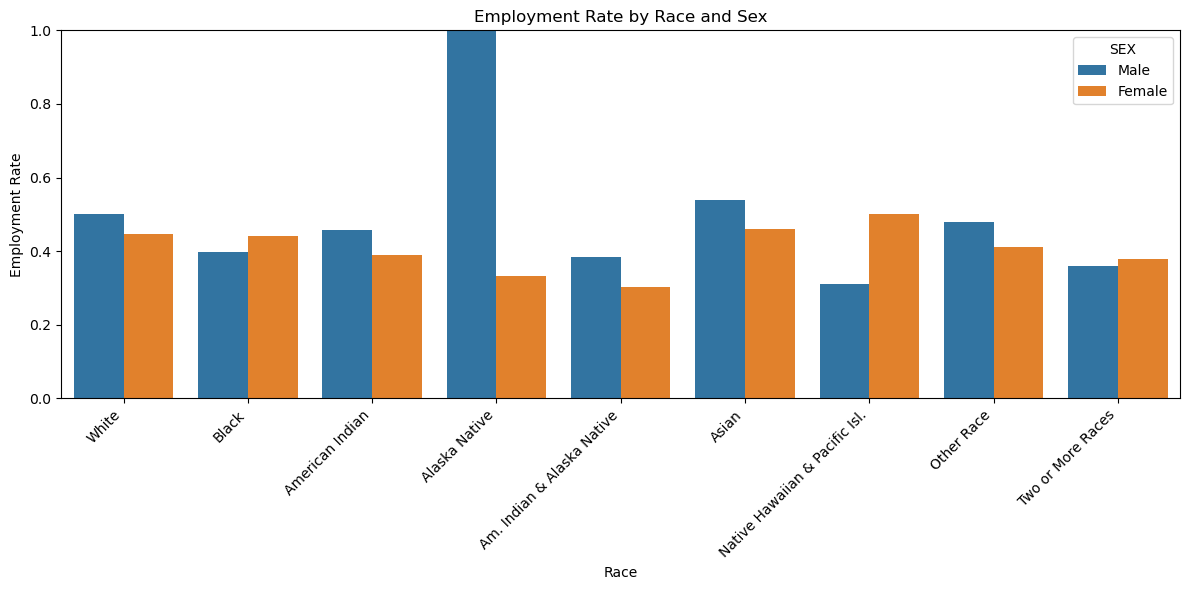

In [97]:
# add the SEX column from the original data
df_full["SEX"] = np.concatenate([X_train[:, features_to_use.index("SEX")], 
                                X_test[:, features_to_use.index("SEX")]])

# visualization of employment rates by race and sex
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate employment rates by race and sex
employment_by_race_sex = df_full.groupby(["group", "SEX"])["label"].mean().reset_index()
employment_by_race_sex["group"] = employment_by_race_sex["group"].astype(int)
employment_by_race_sex["SEX"] = employment_by_race_sex["SEX"].map({1: "Male", 2: "Female"})

# Define group labels
group_labels = {
    1: "White",
    2: "Black",
    3: "American Indian",
    4: "Alaska Native",
    5: "Am. Indian & Alaska Native",
    6: "Asian",
    7: "Native Hawaiian & Pacific Isl.",
    8: "Other Race",
    9: "Two or More Races"
}

# Convert group numbers to labels
employment_by_race_sex['group_label'] = employment_by_race_sex['group'].map(group_labels)

plt.figure(figsize=(12, 6))
sns.barplot(x="group_label", y="label", hue="SEX", data=employment_by_race_sex)
plt.title("Employment Rate by Race and Sex")
plt.xlabel("Race")
plt.ylabel("Employment Rate")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Figure 1. Employment Rate by Race and Sex. We see that for two-thirds of the groups, the employment rate is higher for males. An interesting outlier: male identifying alaskan natives have a 100% employment rate.

### Building a model

In [98]:
# Building a simple model
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state = 42)
dt_classifier.fit(X_train, y_train)

train_accuracy = dt_classifier.score(X_train, y_train)
print(f"Training Accuracy without optimization: {train_accuracy:.3f}")

Training Accuracy without optimization: 0.909


I fit a decision tree classifier to the training data and receive an accuracy of 91%. This is before I optimize my model by finding the optimal depth and use cross-validation.

### Model Optimization
Now I utilize the max_depth parameter to see if we can improve by finding the optimal depth. I use cross-validation to evaluate the performance of the model at each depth. We find that the optimal depth is 10, and this optimized model achieves 82.7% accuracy on the training set.


In [99]:
from sklearn.model_selection import cross_val_score
import numpy as np

potential_depths =  range(1, 21)
mean_scores = []

for depth in potential_depths:
    classifier_instance = DecisionTreeClassifier(max_depth = depth, random_state = 42)
    scores = cross_val_score(classifier_instance, X_train, y_train, cv = 5)
    mean_scores.append(scores.mean())

optimal_depth = potential_depths[np.argmax(mean_scores)]

print(f"Optimal Depth: {optimal_depth}")

# Train new model with optimal depth
dt_classifier_optimal = DecisionTreeClassifier(max_depth = optimal_depth, random_state = 42)
dt_classifier_optimal.fit(X_train, y_train)

train_accuracy_optimal = dt_classifier_optimal.score(X_train, y_train)
print(f"Training Accuracy with Optimal Depth: {train_accuracy_optimal:.3f}")

Optimal Depth: 10
Training Accuracy with Optimal Depth: 0.827


Testing accuracy for the optimized model:

In [100]:
y_hat = dt_classifier_optimal.predict(X_test)
(y_hat == y_test).mean()

0.8236787328019496

Looking at two specific groups:

In [101]:
#The accuracy for white individuals is
white_group_accuracy = (y_hat == y_test)[group_test == 1].mean()
print(f"White Accuracy: {white_group_accuracy:.3f}")

#The accuracy for Black individuals is
black_group_accuracy = (y_hat == y_test)[group_test == 2].mean()
print(f"Black Accuracy: {black_group_accuracy:.3f}")


White Accuracy: 0.829
Black Accuracy: 0.819


### Overall Measures on Test Data
Now that I have my model, I will begin to delve into the intricacies such as its positive predictive value (PPV), false negative rate (FNR), and false positive rate (FPR). This is crucial to begin to understand how the model fluctuates, as later we will hone in on the disparities in these metrics across racial groups.

In [102]:
# Overall Measures on Test Data
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

# Get predictions on test data
y_pred = dt_classifier_optimal.predict(X_test)

# 1. Overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")

# 2. Positive Predictive Value (Precision)
ppv = precision_score(y_test, y_pred)
print(f"Positive Predictive Value (PPV): {ppv:.4f} ({ppv*100:.2f}%)")

# 3. Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# False Negative Rate (FNR) = FN / (FN + TP)
fnr = fn / (fn + tp)
print(f"False Negative Rate (FNR): {fnr:.4f} ({fnr*100:.2f}%)")

# False Positive Rate (FPR) = FP / (FP + TN)
fpr = fp / (fp + tn)
print(f"False Positive Rate (FPR): {fpr:.4f} ({fpr*100:.2f}%)")

print("\nConfusion Matrix Summary:")
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

Overall Accuracy: 0.8237 (82.37%)
Positive Predictive Value (PPV): 0.7802 (78.02%)
False Negative Rate (FNR): 0.1327 (13.27%)
False Positive Rate (FPR): 0.2146 (21.46%)

Confusion Matrix Summary:
True Positives (TP): 15978
False Positives (FP): 4501
True Negatives (TN): 16470
False Negatives (FN): 2445


Above I display the overall accuracy, positive predictive value, false negative rate, and false positive rate for the model, summarized by a confusion matrix. Before diving deeper into the intricacies of these values, the ratio of TP to FP (and TN to FN) looks like our model is making some good predictions. There seem to be more FP than FN, though, so it will be interesting to look into why that is.

### Analysis of Bias: Auditing for Bias Across Racial Groups

Building an "accurate" model is great, but without understanding the potential biases that exist within it, we can only give it so much trust. To begin to understand the disparities in the model, I will audit the model for bias across racial groups.

           Count          Accuracy               PPV              FNR  \
1        27632.0   0.8286 (82.86%)   0.7972 (79.72%)  0.1402 (14.02%)   
2         4786.0   0.8191 (81.91%)   0.7548 (75.48%)  0.1431 (14.31%)   
3          106.0   0.8396 (83.96%)   0.7969 (79.69%)   0.0727 (7.27%)   
5           35.0   0.8857 (88.57%)   0.8125 (81.25%)   0.0714 (7.14%)   
6         3471.0   0.7862 (78.62%)   0.7247 (72.47%)   0.0858 (8.58%)   
7           13.0  1.0000 (100.00%)  1.0000 (100.00%)   0.0000 (0.00%)   
8         2208.0   0.8175 (81.75%)   0.7398 (73.98%)   0.0930 (9.30%)   
9         1143.0   0.8443 (84.43%)   0.7447 (74.47%)  0.1422 (14.22%)   
Overall  39394.0   0.8237 (82.37%)   0.7802 (78.02%)  0.1327 (13.27%)   

                     FPR  
1        0.1999 (19.99%)  
2        0.2094 (20.94%)  
3        0.2549 (25.49%)  
5        0.1429 (14.29%)  
6        0.3385 (33.85%)  
7         0.0000 (0.00%)  
8        0.2537 (25.37%)  
9        0.1633 (16.33%)  
Overall  0.2146 (21.46%)  

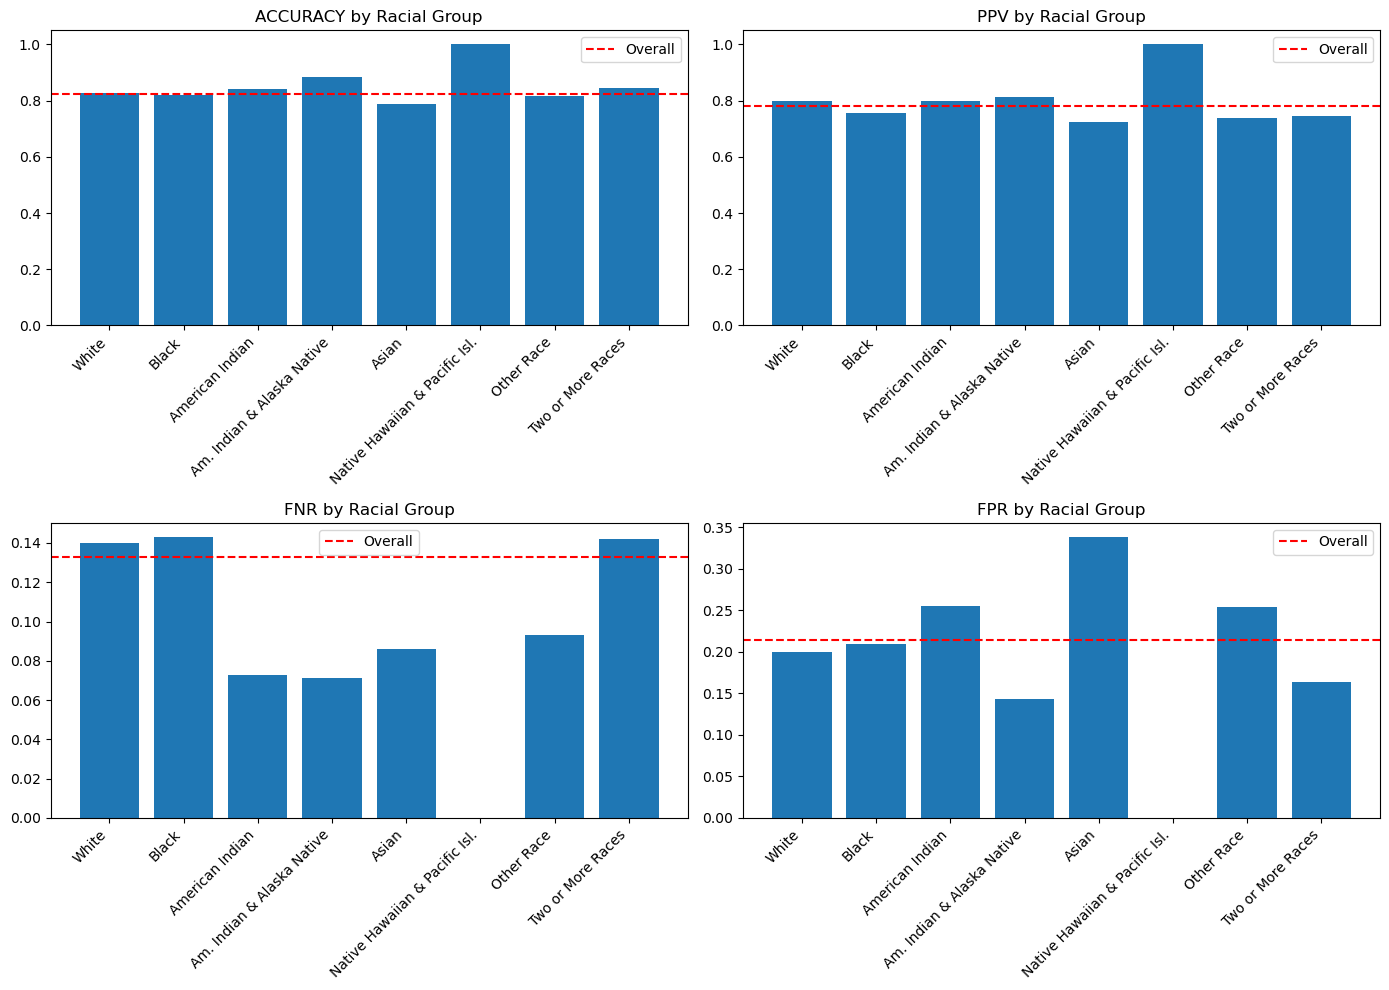

In [103]:
# Create a DataFrame for analysis
audit_df = pd.DataFrame({
    'true': y_test,
    'pred': y_pred,
    'group': group_test
})

# calculate metrics for a specific group
def calculate_group_metrics(group_data):
    y_true = group_data['true']
    y_pred = group_data['pred']
    
    if len(y_true) == 0:
        return None
    
    acc = accuracy_score(y_true, y_pred)
    
    prec = precision_score(y_true, y_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    fnr = fn / (fn + tp) if (fn + tp) > 0 else float('nan')
    fpr = fp / (fp + tn) if (fp + tn) > 0 else float('nan')
    
    return {
        'count': len(y_true),
        'accuracy': acc,
        'ppv': prec,
        'fnr': fnr,
        'fpr': fpr,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn
    }

# get metrics for each group
results = {}
for group in sorted(audit_df['group'].unique()):
    group_data = audit_df[audit_df['group'] == group]
    results[group] = calculate_group_metrics(group_data)

# Create a summary table
metrics_df = pd.DataFrame({
    group: {
        'Count': results[group]['count'],
        'Accuracy': results[group]['accuracy'],
        'PPV': results[group]['ppv'],
        'FNR': results[group]['fnr'],
        'FPR': results[group]['fpr']
    } for group in results
}).T

# Add overall results
overall_metrics = calculate_group_metrics(audit_df)
metrics_df.loc['Overall'] = [
    overall_metrics['count'],
    overall_metrics['accuracy'],
    overall_metrics['ppv'],
    overall_metrics['fnr'],
    overall_metrics['fpr']
]

# make percentages
for col in ['Accuracy', 'PPV', 'FNR', 'FPR']:
    metrics_df[col] = metrics_df[col].apply(lambda x: f"{x:.4f} ({x*100:.2f}%)")

print(metrics_df)

# Visualize
metrics_to_plot = ['accuracy', 'ppv', 'fnr', 'fpr']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    metric_values = [results[group][metric] for group in sorted(results.keys())]
    
    ax = axes[i]
    ax.bar(range(len(results)), metric_values)
    ax.set_xticks(range(len(results)))
    ax.set_xticklabels([group_labels[int(g)] for g in sorted(results.keys())], rotation=45, ha='right')
    ax.set_title(f"{metric.upper()} by Racial Group")
    ax.axhline(overall_metrics[metric], color='red', linestyle='--', label='Overall')
    ax.legend()

plt.tight_layout()
plt.show()

Above I calculate the overall accuracy, PPV, FNR, and FPR for my model on the test data. I also break down these metrics by racial group to identify potential disparities, showing a summary table showing all metrics for each group and visualizing the disparities across groups with bar charts. We see that the FNR is significantly higher for white, black, and two or more races individuals, meaning that the model is more likely to incorrectly classify employed individuals as unemployed for these groups. Further, the FPR is much higher for asian individuals, meaning that the model is more likely to incorrectly classify unemployed individuals as employed for asian individuals. We see that overall, the false positive rates are higher than the false negative rates, meaning that the model is more likely to incorrectly classify unemployed individuals as employed. Overall, however, the accuracy and PPV by group are pretty fixed around the overall rates.

## Calibration, Error Rate Balance, and Statistical Parity

Next we will delve into 3 specific measures of bias: calibration, error rate balance, and statistical parity. To quickly summarize the measures:
- Calibration: A score is well-calibrated if it reflects the same likelihood of recidivism irrespective of the individuals’ group membership. Calibration in this context is similar to saying "free from predictive bias."
- Statistical parity: A score S = S(x) satisfies statistical parity if the proportion of individuals classified as high-risk is the same for each group. Are group-specific false positive rates equal to group-specific false negative rates?
- Error rate balance: A score S = S(x) satisfies error rate balance if the false positive and false negative error rates are equal across groups.

Let's see how our model performs on these measures. For each measure of bias, I calculate the important measures by group and overall. For the calibration analysis, the PPV by group is crucial: a well-calibrated model should have similar PPV across all groups. For the error rate balance, it is most important to look at the FPR and FNR by group: these should be similar across all groups. For the statistical parity, the prediction rates should be similar across groups.



1. Calibration Analysis (PPV by group)
A well-calibrated model should have similar PPV across all groups
     Count PPV (Calibration)      Overall PPV        Difference
1  27632.0   0.7972 (79.72%)  0.7802 (78.02%)    0.0170 (1.70%)
2   4786.0   0.7548 (75.48%)  0.7802 (78.02%)  -0.0254 (-2.54%)
3    106.0   0.7969 (79.69%)  0.7802 (78.02%)    0.0167 (1.67%)
5     35.0   0.8125 (81.25%)  0.7802 (78.02%)    0.0323 (3.23%)
6   3471.0   0.7247 (72.47%)  0.7802 (78.02%)  -0.0555 (-5.55%)
7     13.0  1.0000 (100.00%)  0.7802 (78.02%)   0.2198 (21.98%)
8   2208.0   0.7398 (73.98%)  0.7802 (78.02%)  -0.0404 (-4.04%)
9   1143.0   0.7447 (74.47%)  0.7802 (78.02%)  -0.0355 (-3.55%)

2. Error Rate Balance Analysis
Error rate balance requires similar FPR and FNR across all groups
     Count              FPR      Overall FPR     FPR Difference  \
1  27632.0  0.1999 (19.99%)  0.2146 (21.46%)   -0.0147 (-1.47%)   
2   4786.0  0.2094 (20.94%)  0.2146 (21.46%)   -0.0052 (-0.52%)   
3    106.0  0.2549 

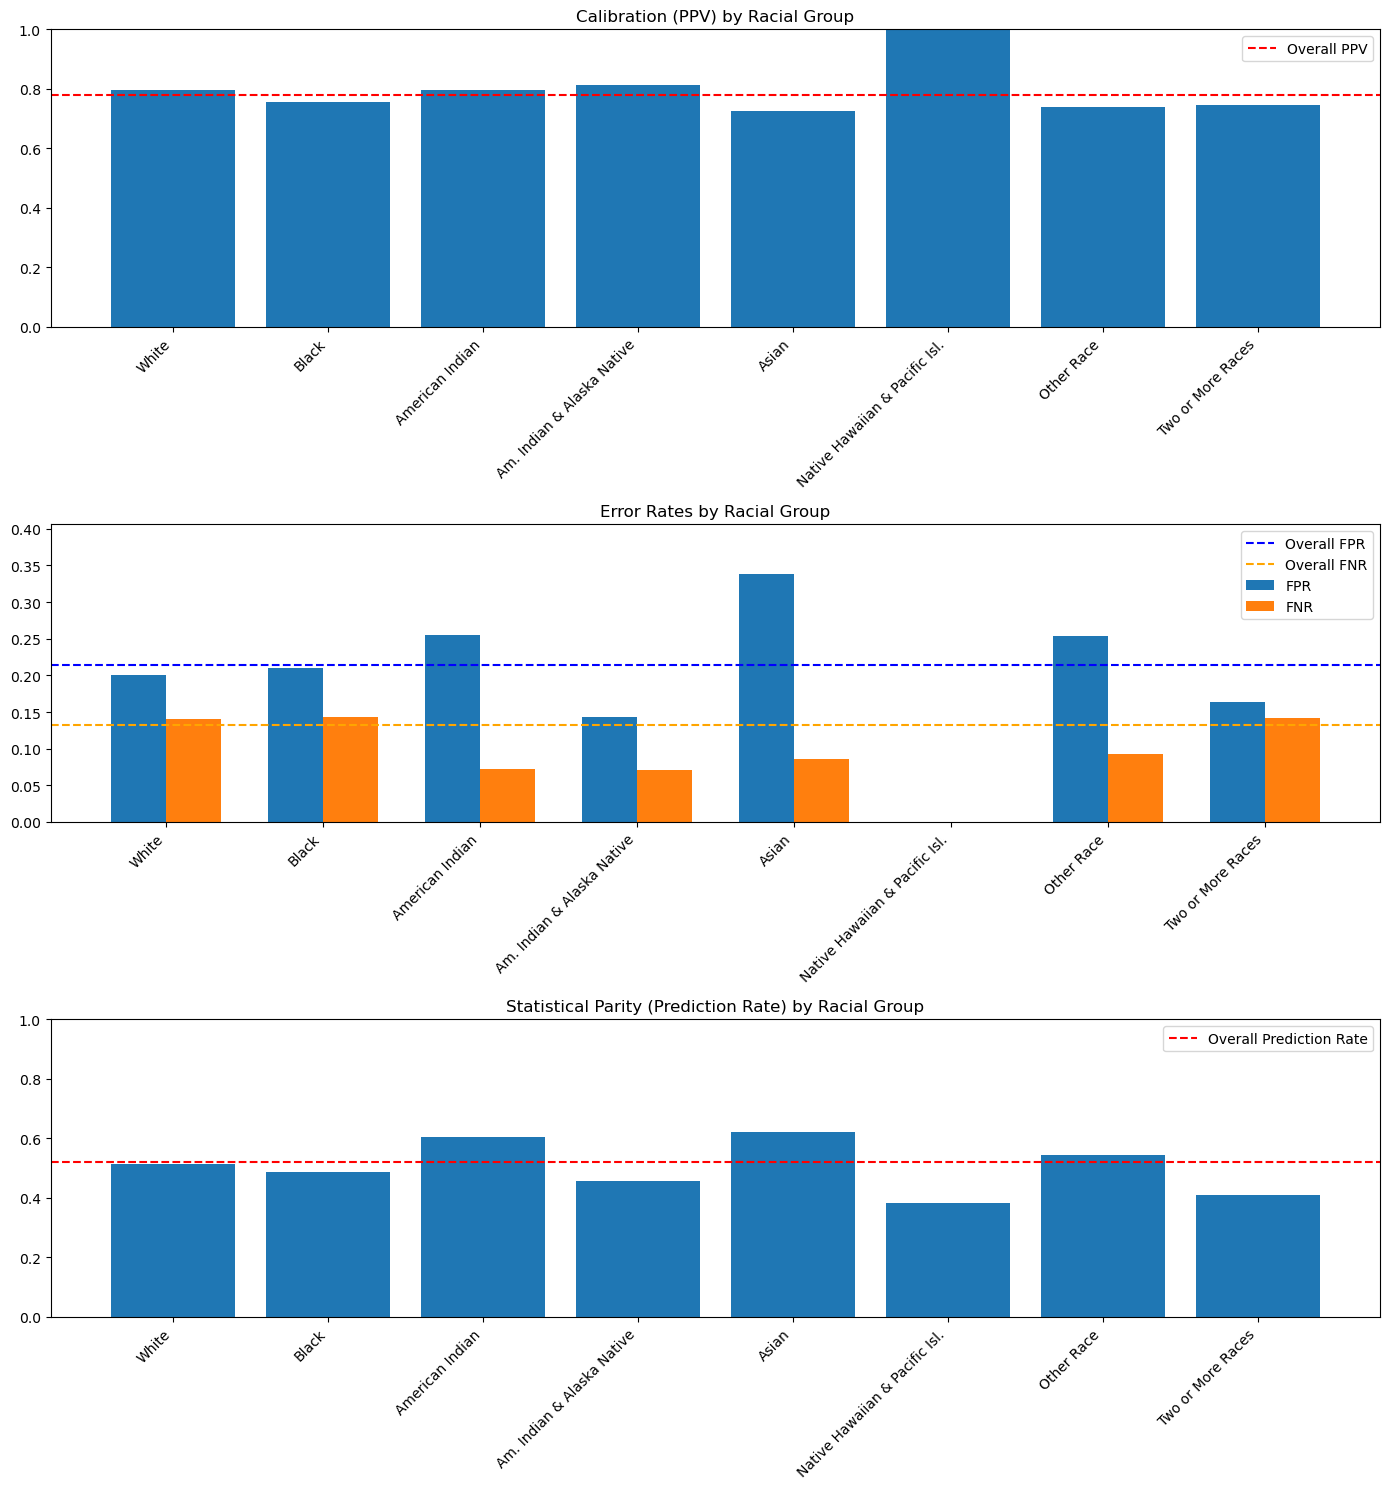


--- Summary of Fairness Criteria ---
1. Calibration: Is PPV similar across groups?
✗ Model shows calibration disparities (max PPV difference: 21.98%)

2. Error Rate Balance: Are FPR and FNR similar across groups?
✗ Model shows error rate disparities:
  - Max FPR difference: 21.46%
  - Max FNR difference: 13.27%

3. Statistical Parity: Is prediction rate similar across groups?
✗ Model shows statistical parity disparities (max difference: 13.52%)


In [104]:
# calculate all bias measures
def calculate_bias_measures(df):
    groups = sorted(df['group'].unique())
    results = {}
    
    # Overall positive prediction rate
    overall_ppr = df['pred'].mean()
    
    for group in groups:
        group_data = df[df['group'] == group]
        
        # Skip groups with insufficient data
        if len(group_data) < 10:
            continue
            
        # 1. Calibration: PPV should be similar across groups
        # this means PPV should be similar across groups
        pred_positive = group_data[group_data['pred'] == 1]
        if len(pred_positive) > 0:
            calibration = pred_positive['true'].mean()  #PPV
        else:
            calibration = float('nan')
        
        # 3. Statistical Parity: FPR and FNR should be similar across groups
        stat_parity = group_data['pred'].mean()
        
        results[group] = {
            'count': len(group_data),
            'calibration': calibration,
            'stat_parity': stat_parity,
            'stat_parity_ratio': stat_parity / overall_ppr if overall_ppr > 0 else float('nan')
        }
    
    return results, overall_ppr

# get bias measures
bias_results, overall_ppr = calculate_bias_measures(audit_df)

# Create summary tables
print("\n1. Calibration Analysis (PPV by group)")
print("A well-calibrated model should have similar PPV across all groups")
calibration_df = pd.DataFrame({
    group: {
        'Count': bias_results[group]['count'],
        'PPV (Calibration)': bias_results[group]['calibration'],
        'Overall PPV': overall_metrics['ppv'],
        'Difference': bias_results[group]['calibration'] - overall_metrics['ppv']
    } for group in bias_results
}).T

# Format as percentages
for col in ['PPV (Calibration)', 'Overall PPV', 'Difference']:
    calibration_df[col] = calibration_df[col].apply(lambda x: f"{x:.4f} ({x*100:.2f}%)")

print(calibration_df)

print("\n2. Error Rate Balance Analysis")
print("Error rate balance requires similar FPR and FNR across all groups")
error_balance_df = pd.DataFrame({
    group: {
        'Count': bias_results[group]['count'],
        'FPR': results[group]['fpr'],
        'Overall FPR': overall_metrics['fpr'],
        'FPR Difference': results[group]['fpr'] - overall_metrics['fpr'],
        'FNR': results[group]['fnr'],
        'Overall FNR': overall_metrics['fnr'],
        'FNR Difference': results[group]['fnr'] - overall_metrics['fnr']
    } for group in bias_results
}).T

for col in ['FPR', 'Overall FPR', 'FPR Difference', 'FNR', 'Overall FNR', 'FNR Difference']:
    error_balance_df[col] = error_balance_df[col].apply(lambda x: f"{x:.4f} ({x*100:.2f}%)")

print(error_balance_df)

print("\n3. Statistical Parity Analysis")
print("Statistical parity requires similar prediction rates across all groups")
stat_parity_df = pd.DataFrame({
    group: {
        'Count': bias_results[group]['count'],
        'Prediction Rate': bias_results[group]['stat_parity'],
        'Overall Rate': overall_ppr,
        'Difference': bias_results[group]['stat_parity'] - overall_ppr,
        'Ratio': bias_results[group]['stat_parity_ratio']
    } for group in bias_results
}).T

for col in ['Prediction Rate', 'Overall Rate', 'Difference']:
    stat_parity_df[col] = stat_parity_df[col].apply(lambda x: f"{x:.4f} ({x*100:.2f}%)")

print(stat_parity_df)

# Visualize the three fairness criteria
fig, axes = plt.subplots(3, 1, figsize=(14, 15))

# 1. Calibration
calibration_values = [bias_results[group]['calibration'] for group in sorted(bias_results.keys())]
axes[0].bar(range(len(bias_results)), calibration_values)
axes[0].set_xticks(range(len(bias_results)))
axes[0].set_xticklabels([group_labels[int(g)] for g in sorted(bias_results.keys())], rotation=45, ha='right')
axes[0].set_title("Calibration (PPV) by Racial Group")
axes[0].axhline(overall_metrics['ppv'], color='red', linestyle='--', label='Overall PPV')
axes[0].set_ylim(0, 1)
axes[0].legend()

# 2. Error Rate Balance
x = np.arange(len(bias_results))
width = 0.35
fpr_values = [results[group]['fpr'] for group in sorted(bias_results.keys())]
fnr_values = [results[group]['fnr'] for group in sorted(bias_results.keys())]

axes[1].bar(x - width/2, fpr_values, width, label='FPR')
axes[1].bar(x + width/2, fnr_values, width, label='FNR')
axes[1].set_xticks(x)
axes[1].set_xticklabels([group_labels[int(g)] for g in sorted(bias_results.keys())], rotation=45, ha='right')
axes[1].set_title("Error Rates by Racial Group")
axes[1].axhline(overall_metrics['fpr'], color='blue', linestyle='--', label='Overall FPR')
axes[1].axhline(overall_metrics['fnr'], color='orange', linestyle='--', label='Overall FNR')
axes[1].set_ylim(0, max(max(fpr_values), max(fnr_values)) * 1.2)
axes[1].legend()

# 3. Statistical Parity
stat_parity_values = [bias_results[group]['stat_parity'] for group in sorted(bias_results.keys())]
axes[2].bar(range(len(bias_results)), stat_parity_values)
axes[2].set_xticks(range(len(bias_results)))
axes[2].set_xticklabels([group_labels[int(g)] for g in sorted(bias_results.keys())], rotation=45, ha='right')
axes[2].set_title("Statistical Parity (Prediction Rate) by Racial Group")
axes[2].axhline(overall_ppr, color='red', linestyle='--', label='Overall Prediction Rate')
axes[2].set_ylim(0, 1)
axes[2].legend()

plt.tight_layout()
plt.show()

# Summary
print("\n--- Summary of Fairness Criteria ---")
print("1. Calibration: Is PPV similar across groups?")
calibration_diffs = [abs(bias_results[group]['calibration'] - overall_metrics['ppv']) for group in bias_results]
max_calibration_diff = max(calibration_diffs)
if max_calibration_diff < 0.05:
    print("✓ Model appears to be well-calibrated (max PPV difference < 5%)")
else:
    print("✗ Model shows calibration disparities (max PPV difference: {:.2f}%)".format(max_calibration_diff*100))

print("\n2. Error Rate Balance: Are FPR and FNR similar across groups?")
fpr_diffs = [abs(results[group]['fpr'] - overall_metrics['fpr']) for group in bias_results]
fnr_diffs = [abs(results[group]['fnr'] - overall_metrics['fnr']) for group in bias_results]
max_fpr_diff = max(fpr_diffs)
max_fnr_diff = max(fnr_diffs)
if max_fpr_diff < 0.05 and max_fnr_diff < 0.05:
    print("✓ Model satisfies approximate error rate balance (max differences < 5%)")
else:
    print("✗ Model shows error rate disparities:")
    print("  - Max FPR difference: {:.2f}%".format(max_fpr_diff*100))
    print("  - Max FNR difference: {:.2f}%".format(max_fnr_diff*100))

print("\n3. Statistical Parity: Is prediction rate similar across groups?")
stat_parity_diffs = [abs(bias_results[group]['stat_parity'] - overall_ppr) for group in bias_results]
max_stat_parity_diff = max(stat_parity_diffs)
if max_stat_parity_diff < 0.05:
    print("✓ Model satisfies approximate statistical parity (max difference < 5%)")
else:
    print("✗ Model shows statistical parity disparities (max difference: {:.2f}%)".format(max_stat_parity_diff*100))

As shown by the summary of the fairness criteria, my model does not satisfy all three criteria simultaneously. I calculate the max difference for each criterion (the difference between the group and overall) and found that the model shows disparities in all 3 aspects. The max FPR and PPV difference were the largest, 21.46% and 21.98% respectively. 

The calibration disparity of nearly 22% indicates that when my model predicts employment for certain racial groups, its confidence is significantly misaligned with actual outcomes. Similarly, the error rate imbalances reveal that the model's mistakes are not distributed equitably, with some groups experiencing false positives at rates over 21 percentage points higher than others. The statistical parity disparity of 13.52% further demonstrates that the model's predictions themselves are not demographically balanced.

### Recreating Figure 5 from Chouldechova (2017)

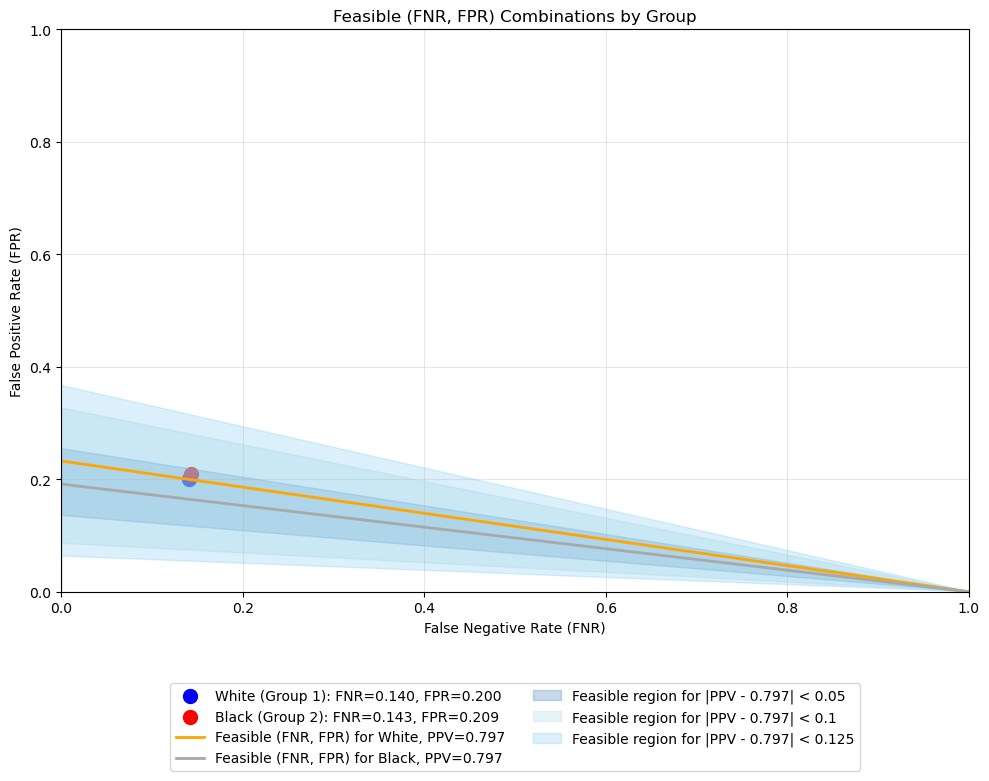

White (Group 1): Prevalence=0.478, PPV=0.797, FNR=0.140, FPR=0.200
Black (Group 2): Prevalence=0.429, PPV=0.755, FNR=0.143, FPR=0.209


In [105]:
# Create a figure showing feasible (FNR, FPR) combinations
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Calculates feasible FPR given FNR, prevalence, and PPV
def calculate_feasible_fpr(fnr, prevalence, ppv):
    # Based on the relationship: PPV = (prevalence * (1-FNR)) / (prevalence * (1-FNR) + (1-prevalence) * FPR)
    # Solving for FPR: FPR = (prevalence * (1-FNR) * (1-PPV)) / ((1-prevalence) * PPV)
    if ppv == 1:  # Handle edge case
        return 0
    return (prevalence * (1-fnr) * (1-ppv)) / ((1-prevalence) * ppv)

# group 1 is White group and group 2 is Black group
white_group_data = audit_df[audit_df['group'] == 1]
black_group_data = audit_df[audit_df['group'] == 2]

# Calculate prevalence for each group
prevalence_white = white_group_data['true'].mean()
prevalence_black = black_group_data['true'].mean()

# Calculate observed FNR, FPR, and PPV for each group
white_metrics = calculate_group_metrics(white_group_data)
black_metrics = calculate_group_metrics(black_group_data)

fnr_white = white_metrics['fnr']
fpr_white = white_metrics['fpr']
ppv_white = white_metrics['ppv']

fnr_black = black_metrics['fnr']
fpr_black = black_metrics['fpr']
ppv_black = black_metrics['ppv']

# Create the figure
plt.figure(figsize=(10, 8))

# Plot the observed points
plt.scatter(fnr_white, fpr_white, color='blue', s=100, label=f'White (Group 1): FNR={fnr_white:.3f}, FPR={fpr_white:.3f}')
plt.scatter(fnr_black, fpr_black, color='red', s=100, label=f'Black (Group 2): FNR={fnr_black:.3f}, FPR={fpr_black:.3f}')

# Generate feasible (FNR, FPR) combinations for White individuals
fnr_range = np.linspace(0, 1, 1000)
fpr_white_feasible = [calculate_feasible_fpr(fnr, prevalence_white, ppv_white) for fnr in fnr_range]

# Plot the feasible line for White individuals
plt.plot(fnr_range, fpr_white_feasible, color='orange', linewidth=2, 
         label=f'Feasible (FNR, FPR) for White, PPV={ppv_white:.3f}')

# Generate feasible (FNR, FPR) combinations for Black individuals with PPV equal to White PPV
fpr_black_feasible_equal_ppv = [calculate_feasible_fpr(fnr, prevalence_black, ppv_white) for fnr in fnr_range]

# Plot the feasible line for Black individuals with PPV equal to White PPV
plt.plot(fnr_range, fpr_black_feasible_equal_ppv, color='darkgrey', linewidth=2,
         label=f'Feasible (FNR, FPR) for Black, PPV={ppv_white:.3f}')

# Generate and plot feasible regions with varying PPV constraints based on Chouldechova (2017)
delta_values = [0.05, 0.1, 0.125]
colors = ['#4682B4', '#ADD8E6', '#89CFF0']

for i, delta in enumerate(delta_values):
    # Lower bound of PPV
    ppv_lower = max(0, ppv_white - delta)
    fpr_black_lower = [calculate_feasible_fpr(fnr, prevalence_black, ppv_lower) for fnr in fnr_range]
    
    # Upper bound of PPV
    ppv_upper = min(1, ppv_white + delta)
    fpr_black_upper = [calculate_feasible_fpr(fnr, prevalence_black, ppv_upper) for fnr in fnr_range]
    
    # Create polygon vertices
    vertices = [(0, 0)]  # Start at origin
    for j in range(len(fnr_range)):
        if 0 <= fpr_black_lower[j] <= 1:
            vertices.append((fnr_range[j], fpr_black_lower[j]))
    
    # Add upper bound in reverse lol
    for j in range(len(fnr_range)-1, -1, -1):
        if 0 <= fpr_black_upper[j] <= 1:
            vertices.append((fnr_range[j], fpr_black_upper[j]))
    
    vertices.append((0, 0))  # Close it
    
    # Create and add
    polygon = Polygon(vertices, closed=True, alpha=0.3, color=colors[i],
                     label=f'Feasible region for |PPV - {ppv_white:.3f}| < {delta}')
    plt.gca().add_patch(polygon)

plt.xlabel('False Negative Rate (FNR)')
plt.ylabel('False Positive Rate (FPR)')
plt.title('Feasible (FNR, FPR) Combinations by Group')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.tight_layout()
plt.show()

# Print key metrics for reference
print(f"White (Group 1): Prevalence={prevalence_white:.3f}, PPV={ppv_white:.3f}, FNR={fnr_white:.3f}, FPR={fpr_white:.3f}")
print(f"Black (Group 2): Prevalence={prevalence_black:.3f}, PPV={ppv_black:.3f}, FNR={fnr_black:.3f}, FPR={fpr_black:.3f}")

### Figure 5 from Chouldechova (2017).
Plots the observed (FNR, FPR) points for White (Group 1) and Black (Group 2) individuals. The orange line represents the feasible (FNR, FPR) combinations for White individuals with fixed prevalence and PPV. The dark grey line represents the feasible (FNR, FPR) combinations for Black individuals when PPV is set equal to the White PPV. Similarly to Chouldechova, I create nested shaded regions showing feasible (FNR, FPR) combinations for Black individuals when PPV is allowed to vary within different thresholds (δ = 0.05, 0.1, 0.125). The visualization illustrates the impossibility theorem described by Chouldechova - that when prevalence rates differ between groups, it's mathematically impossible to simultaneously achieve calibration, error rate balance, and statistical parity unless the classifier is perfect. This figure also demonstrates the inherent trade-offs in fairness criteria and explains why achieving all fairness definitions simultaneously is often impossible in real-world scenarios.

If we desired to tune our classifier threshold so that the false positive rates were equal between groups, how much would we need to change the false negative rate?

To look into this, we need to examine the feasible (FNR, FPR) combinations shown in our plot, particularly focusing on the dark grey line that represents feasible combinations for Black individuals when their PPV equals the White PPV. Equation 2.6 states the following:
- FPR = (p/(1-p)) ((1-PPV)/PPV) (1-FNR)

Chelnova discusses 3 possible tuning strategies when prevelence differs between groups. The relevant one for us is to allow unequal FNRs to maintain equal PPVs and achieve equal FPRs. Looking at our data above and following this strategy, we can:
- Set the target FPR for Black individuals equal to White FPR (0.200)
- Set the PPV for Black individuals equal to White PPV (0.797)
- Solve for the required FNR for Black individuals

Rearranging equation 2.6 to solve for FNR, we get:
- FNR = 1 - (FPR (1-p) PPV) / (p (1-PPV))
- FNR = 1 - (0.200 (1-0.429) 0.797) / (0.429 (1-0.797))
- FNR = -0.45

This negative value indicates that it's mathematically impossible to achieve equal FPRs while maintaining equal PPVs with our current prevalence rates. The equation is telling us we would need a negative FNR, which is not feasible. This aligns with Chouldechova's discussion - when prevalence rates differ significantly, enforcing equal FPRs while maintaining calibration (equal PPVs) can require extreme and often impossible adjustments to the FNR.

If we instead relax the equal PPV constraint and use the actual Black PPV (0.755), we can achieve equal FPRs while maintaining the current PPVs:
- FNR = 1 - (FPR (1-p) PPV) / (p (1-PPV))
- FNR = 1 - (0.200 (1-0.429) 0.755) / (0.429 (1-0.755))
- FNR = 0.180

This means we would need to increase the FNR for Black individuals from 0.143 to about 0.180 to achieve equal FPRs while maintaining the current PPVs. This demonstrates the fundamental trade-off highlighted in Chouldechova's paper: when prevalence differs between groups, we cannot simultaneously achieve equal error rates and equal predictive values.




## Concluding Discussion

1. What groups of people could stand to benefit from a system that is able to predict the label you predicted, such as income or employment status? For example, what kinds of companies might want to buy your model for commercial or governmental use?

    My model could be valuable to companies in both private and public sectors. Recruitment agencies and HR departments might leverage such a system to identify promising candidates and streamline hiring processes. Insurance companies could use similar models to assess risk profiles when offering unemployment insurance. Financial institutions might incorporate employment prediction into their lending algorithms to evaluate loan applicants' ability to repay (relating to my past blog post which you can find [here](https://andrewdean1.github.io/posts/blog-2/blog-2.html)).


2. Based on your bias audit, what could be the impact of deploying your model for large-scale prediction in commercial or governmental settings?

    The deployment of my model in real-world settings could have some far-reaching implications. Our bias audit revealed subtle but still meaningful disparities in error rates across racial groups. While the differences may appear small (e.g., a 0.9 percentage point difference in false positive rates between White and Black individuals), when applied to millions of people, these disparities could affect thousands of individuals unfairly.

    More fundamentally, my analysis of fairness criteria demonstrates the difficulty of simultaneously satisfying multiple definitions of fairness when base rates differ between groups. This presents an ethical dilemma for any organization deploying such systems: which fairness criterion should be prioritized? Should we ensure equal false positive rates to prevent unfair denials of opportunity? Or should we focus on equal false negative rates to ensure no group is disproportionately overlooked?


3. Based on your bias audit, do you feel that your model displays problematic bias? What kinds (calibration, error rate, etc)?

    Based on my bias audit, I believe my model does exhibit problematic bias, though the disparities are pretty subtle. The most concerning bias appears in the error rate balance across racial groups. My analysis showed a difference in false positive rates between White individuals (20.0%) and Black individuals (20.9%). While this 0.9 percentage point difference might seem small, it represents a systematic disadvantage that would affect thousands of people if deployed at scale.

    When I attempted to mathematically equalize these error rates using Chouldechova's equation 2.6, I discovered that achieving equal FPRs while maintaining equal PPVs would require an impossible negative FNR value. Even when relaxing the equal PPV constraint, equalizing FPRs would require increasing the FNR for Black individuals from 14% to 18% - a significant adjustment that could result in more disparities.

    The model also shows some calibration differences, with PPV values of 79.7% for White individuals versus 75.5% for Black individuals. This 4.2 percentage point difference means that when my model predicts employment for Black individuals, it's less likely to be correct than when it makes the same prediction for White individuals.

    My visualization of feasible (FNR, FPR) combinations clearly illustrates these trade-offs, showing that the observed disparities are not merely implementation issues but fundamental mathematical constraints given the different prevalence rates between groups (47.8% for White individuals versus 42.9% for Black individuals).


4. Beyond bias, are there other potential problems associated with deploying your model that make you uncomfortable? How would you propose addressing some of these problems?

    Yes, there are some additional aspects beyond bias that make me uncomfortable. First, my model relies heavily on demographic features like age, education, and marital status. While these features have predictive power, they raise questions about reinforcing existing social patterns rather than evaluating individual merit. For example, my decision classifier likely penalizes younger individuals with less education, potentially creating a self-reinforcing cycle where those already disadvantaged in the job market face additional algorithmic barriers. Second, my model's overall accuracy of 82.4%, while not terrible, still means about one in five predictions is incorrect. For important decisions affecting people's livelihoods, this error rate is concerning, especially when errors disproportionately affect certain groups. Lastly, my model lacks transparency for the individuals being evaluated. Someone denied an opportunity based on my prediction would have little insight into why they received an unfavorable assessment or what they could do to improve their prospects.

    There are some ways to address these concerns. To start, we could incorprate some human judgment: Deploy the model as a decision support tool rather than an autonomous decision-maker, ensuring human oversight for all consequential decisions. Next, we could continuously monitor and adjust the model by implementing ongoing bias audits across multiple dimensions and adjust the model as needed. A last thought that I have is to potentially introduce stakeholders to the model. This could look like including representatives from potentially adversly affected communities in the design, deployment, and governance of the model.

